In [4]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import numpy as np

In [5]:
# Configuración de estilo para los gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [6]:
# Cargar el archivo CSV desde la ruta especificada
csv_resultados_path = "/content/drive/MyDrive/Proyectos/Versiones ChatBot/2 - BERT/respuestas_manual.csv"

try:
    resultados = pd.read_csv(csv_resultados_path)
    print("✅ Archivo cargado correctamente")
    print(f"📊 Total de registros: {len(resultados)}")
    print("\nPrimeras filas del dataset:")
    display(resultados.head())
except Exception as e:
    print(f"❌ Error al cargar el archivo: {e}")
    raise

✅ Archivo cargado correctamente
📊 Total de registros: 102

Primeras filas del dataset:


,tipo_pregunta,pregunta,respuesta_esperada,respuesta_obtenida,puntaje,tiempo_seg
0,simple,¿Qué protocolo se usa para asignar direcciones...,DHCP,una interfaz\n\nContexto usado:\n- técnicament...,1,6.618
1,simple,¿En qué puerto opera el servicio DNS?,53,una consulta que contiene el nombre de host a ...,5,2.117
2,simple,¿En qué consiste DNS?,Traduce nombre de dominio en direcciones IP,una consulta que contiene el nombre de host a ...,2,1.961
3,simple,¿Qué significa ARP?,Address Resolution Protocol,un nodo pasa un paquete de consulta arp al ada...,1,1.911
4,compleja,Explica el proceso de three-way handshake en TCP,"1. Cliente envía SYN, 2. Servidor responde SYN...",No tengo información suficiente para responder...,1,0.124


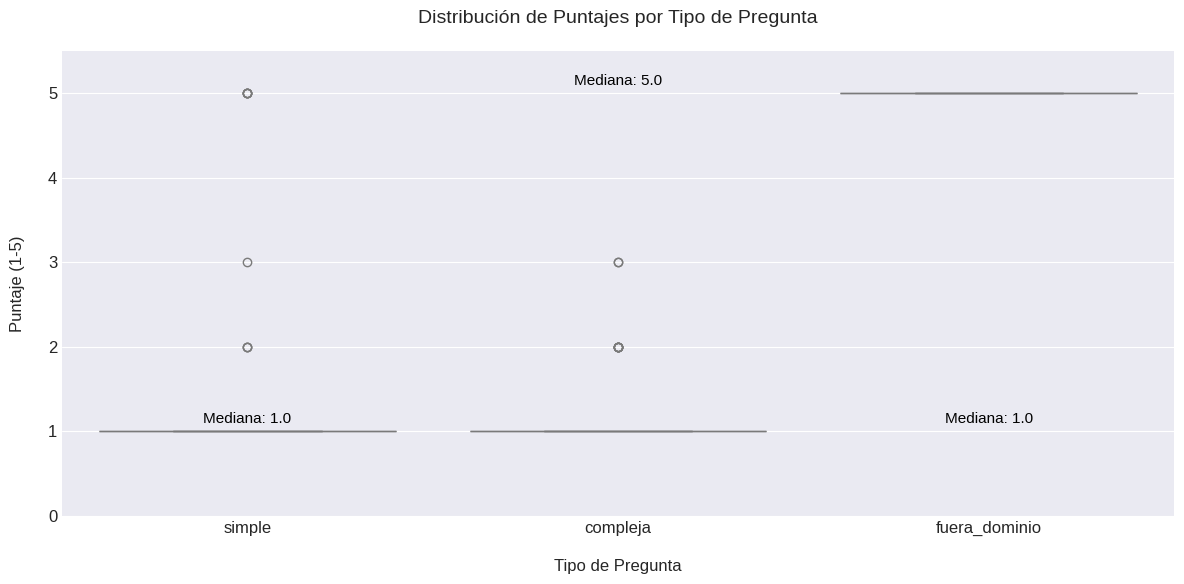

In [7]:
# Gráfico 1: Distribución de puntajes por tipo de pregunta
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='tipo_pregunta', y='puntaje', data=resultados)
plt.title('Distribución de Puntajes por Tipo de Pregunta\n', fontsize=14)
plt.xlabel('\nTipo de Pregunta', fontsize=12)
plt.ylabel('Puntaje (1-5)\n', fontsize=12)
plt.ylim(0, 5.5)

# Añadir valores medios
medians = resultados.groupby('tipo_pregunta')['puntaje'].median()
for i, median in enumerate(medians):
    ax.text(i, median + 0.1, f'Mediana: {median}',
            horizontalalignment='center',
            fontsize=11, color='black')

plt.tight_layout()
plt.show()

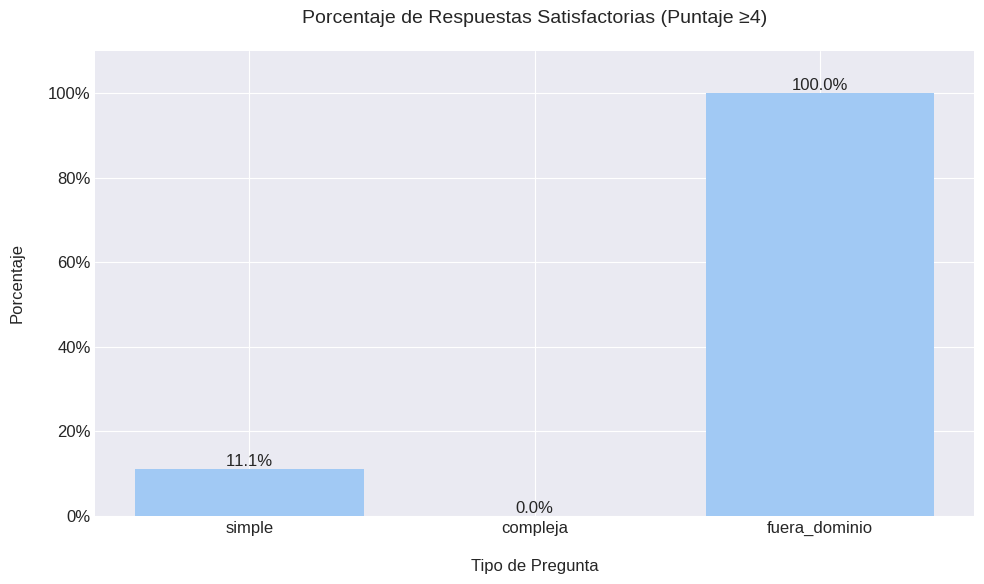

In [8]:
# Gráfico 2: Porcentaje de éxito por categoría (puntaje >=4)
plt.figure(figsize=(10, 6))
categorias = resultados['tipo_pregunta'].unique()
porcentajes = []

for cat in categorias:
    correctas = sum(resultados[resultados['tipo_pregunta'] == cat]['puntaje'] >= 4)
    total = sum(resultados['tipo_pregunta'] == cat)
    porcentajes.append(correctas/total*100)

bars = plt.bar(categorias, porcentajes)
plt.title('Porcentaje de Respuestas Satisfactorias (Puntaje ≥4)\n', fontsize=14)
plt.xlabel('\nTipo de Pregunta', fontsize=12)
plt.ylabel('Porcentaje\n', fontsize=12)
plt.ylim(0, 110)
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))

# Añadir etiquetas con valores
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

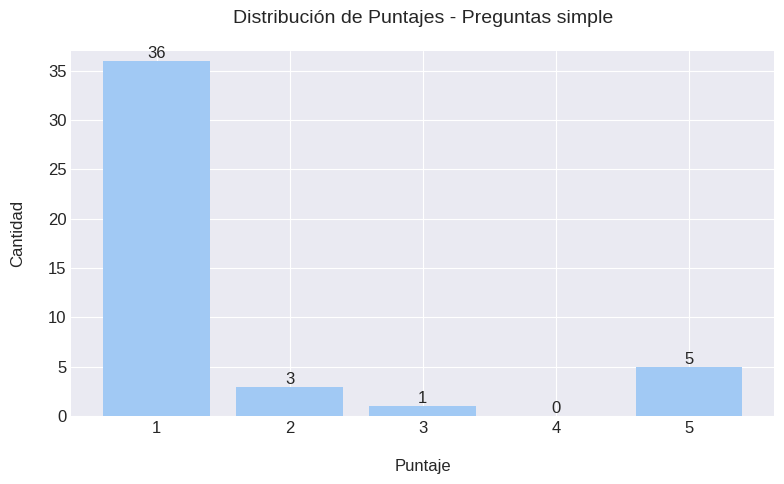

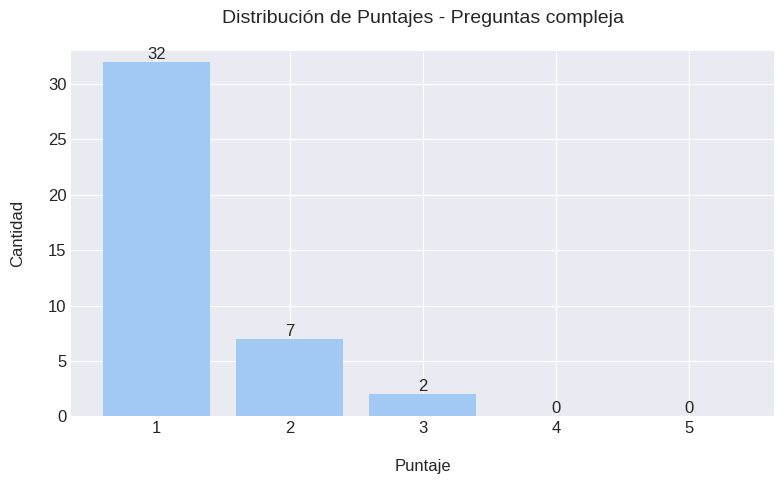

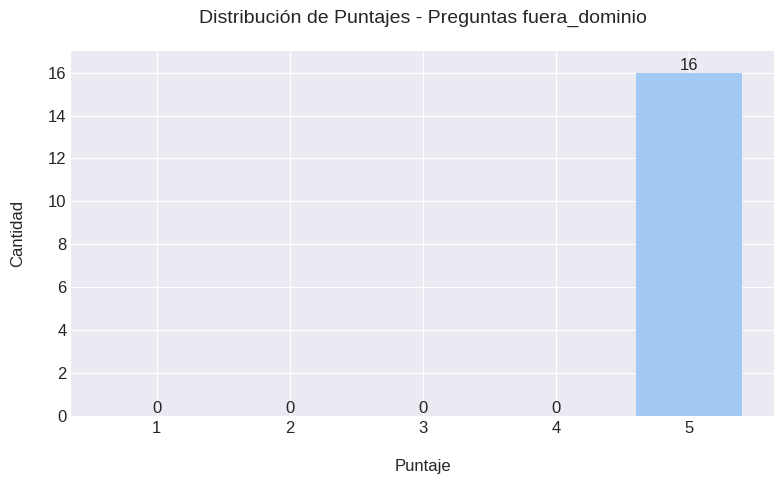

In [9]:
# Gráfico 3: Desglose detallado por tipo de pregunta
for tipo in categorias:
    plt.figure(figsize=(8, 5))
    subset = resultados[resultados['tipo_pregunta'] == tipo]
    counts = subset['puntaje'].value_counts().sort_index()

    # Si faltan algunos puntajes, completamos con 0
    for score in range(1, 6):
        if score not in counts.index:
            counts[score] = 0
    counts = counts.sort_index()

    bars = plt.bar(counts.index, counts.values)
    plt.title(f'Distribución de Puntajes - Preguntas {tipo}\n', fontsize=14)
    plt.xlabel('\nPuntaje', fontsize=12)
    plt.ylabel('Cantidad\n', fontsize=12)
    plt.xticks(range(1, 6))
    plt.ylim(0, counts.max() + 1)

    # Añadir etiquetas
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

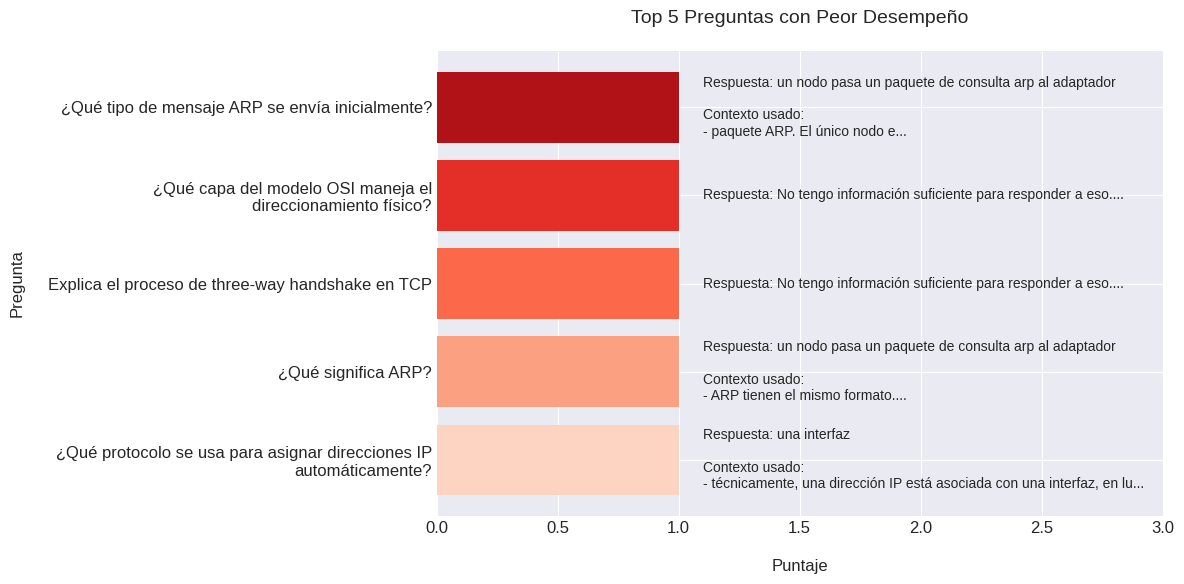

In [10]:
# Gráfico 4: Análisis de errores (si existen)
if sum(resultados['puntaje'] < 3) > 0:
    plt.figure(figsize=(12, 6))
    incorrectas = resultados[resultados['puntaje'] < 3]

    # Top 5 preguntas con peor puntuación
    peores = incorrectas.sort_values('puntaje').head(5)

    # Crear gráfico
    plt.barh(peores['pregunta'].str.wrap(50), peores['puntaje'],
            color=sns.color_palette("Reds", 5))
    plt.title('Top 5 Preguntas con Peor Desempeño\n', fontsize=14)
    plt.xlabel('\nPuntaje', fontsize=12)
    plt.ylabel('Pregunta\n', fontsize=12)
    plt.xlim(0, 3)

    # Añadir respuestas como anotaciones
    for i, (preg, resp) in enumerate(zip(peores['pregunta'], peores['respuesta_obtenida'])):
        plt.text(peores['puntaje'].iloc[i] + 0.1, i,
                f"Respuesta: {resp[:100]}...",
                va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("✅ No hay respuestas con puntaje menor a 3 - Buen desempeño general")

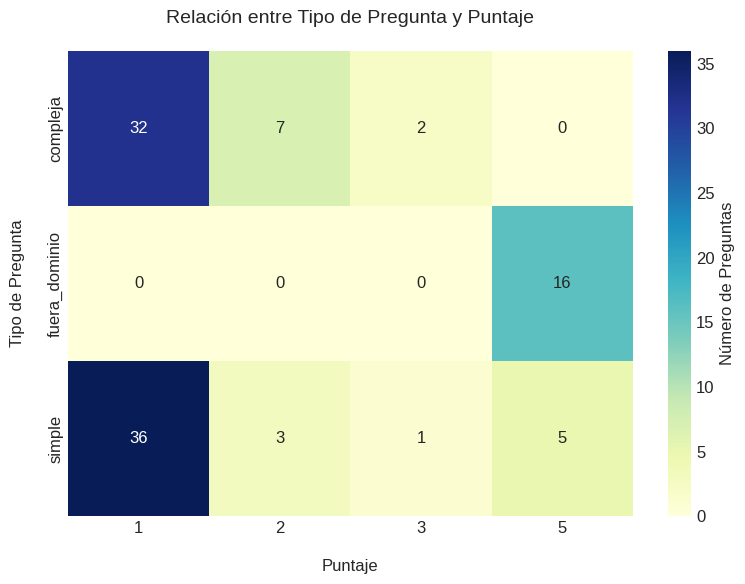

In [11]:
# Gráfico 5: Matriz de calor de precisión por tipo
plt.figure(figsize=(8, 6))
cross_tab = pd.crosstab(resultados['tipo_pregunta'], resultados['puntaje'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu',
           cbar_kws={'label': 'Número de Preguntas'})
plt.title('Relación entre Tipo de Pregunta y Puntaje\n', fontsize=14)
plt.xlabel('\nPuntaje', fontsize=12)
plt.ylabel('Tipo de Pregunta\n', fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# Función para guardar todos los gráficos
def guardar_graficos(resultados):
    try:
        # Configurar la ruta de guardado
        save_path = "/content/drive/MyDrive/Proyectos/Versiones ChatBot/BERT/graficos_analisis/"
        !mkdir -p "{save_path}"

        # Configuración de estilo
        plt.style.use('seaborn-v0_8-darkgrid') # Corrected style name
        sns.set_palette("pastel")
        plt.rcParams['figure.figsize'] = (10, 6)
        plt.rcParams['font.size'] = 12

        # Gráfico 1: Distribución de puntajes por tipo de pregunta
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(x='tipo_pregunta', y='puntaje', data=resultados)
        plt.title('Distribución de Puntajes por Tipo de Pregunta\n', fontsize=14)
        plt.xlabel('\nTipo de Pregunta', fontsize=12)
        plt.ylabel('Puntaje (1-5)\n', fontsize=12)
        plt.ylim(0, 5.5)
        plt.savefig(f"{save_path}1_distribucion_puntajes.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Gráfico 2: Porcentaje de éxito por categoría
        plt.figure(figsize=(10, 6))
        categorias = resultados['tipo_pregunta'].unique()
        porcentajes = []

        for cat in categorias:
            correctas = sum(resultados[resultados['tipo_pregunta'] == cat]['puntaje'] >= 4)
            total = sum(resultados['tipo_pregunta'] == cat)
            porcentajes.append(correctas/total*100)

        bars = plt.bar(categorias, porcentajes)
        plt.title('Porcentaje de Respuestas Satisfactorias (Puntaje ≥4)\n', fontsize=14)
        plt.xlabel('\nTipo de Pregunta', fontsize=12)
        plt.ylabel('Porcentaje\n', fontsize=12)
        plt.ylim(0, 110)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(100))

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=12)

        plt.savefig(f"{save_path}2_porcentaje_aciertos.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Gráfico 3: Desglose por tipo de pregunta
        for tipo in categorias:
            plt.figure(figsize=(8, 5))
            subset = resultados[resultados['tipo_pregunta'] == tipo]
            counts = subset['puntaje'].value_counts().sort_index()

            # Completar con 0 si faltan puntajes
            for score in range(1, 6):
                if score not in counts.index:
                    counts[score] = 0
            counts = counts.sort_index()

            bars = plt.bar(counts.index, counts.values)
            plt.title(f'Distribución de Puntajes - Preguntas {tipo}\n', fontsize=14)
            plt.xlabel('\nPuntaje', fontsize=12)
            plt.ylabel('Cantidad\n', fontsize=12)
            plt.xticks(range(1, 6))
            plt.ylim(0, counts.max() + 1)

            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}',
                        ha='center', va='bottom', fontsize=12)

            plt.savefig(f"{save_path}3_desglose_{tipo}.png", dpi=300, bbox_inches='tight')
            plt.close()

        # Gráfico 4: Análisis de errores (si existen)
        if sum(resultados['puntaje'] < 3) > 0:
            plt.figure(figsize=(12, 6))
            incorrectas = resultados[resultados['puntaje'] < 3]
            peores = incorrectas.sort_values('puntaje').head(5)

            plt.barh(peores['pregunta'].str.wrap(50), peores['puntaje'],
                    color=sns.color_palette("Reds", 5))
            plt.title('Top 5 Preguntas con Peor Desempeño\n', fontsize=14)
            plt.xlabel('\nPuntaje', fontsize=12)
            plt.ylabel('Pregunta\n', fontsize=12)
            plt.xlim(0, 3)

            for i, (preg, resp) in enumerate(zip(peores['pregunta'], peores['respuesta_obtenida'])):
                plt.text(peores['puntaje'].iloc[i] + 0.1, i,
                        f"Respuesta: {resp[:100]}...",
                        va='center', fontsize=10)

            plt.savefig(f"{save_path}4_top_errores.png", dpi=300, bbox_inches='tight')
            plt.close()

        # Gráfico 5: Matriz de calor
        plt.figure(figsize=(8, 6))
        cross_tab = pd.crosstab(resultados['tipo_pregunta'], resultados['puntaje'])
        sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu',
                   cbar_kws={'label': 'Número de Preguntas'})
        plt.title('Relación entre Tipo de Pregunta y Puntaje\n', fontsize=14)
        plt.xlabel('\nPuntaje', fontsize=12)
        plt.ylabel('Tipo de Pregunta\n', fontsize=12)
        plt.savefig(f"{save_path}5_matriz_confusion.png", dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✅ Todos los gráficos guardados en: {save_path}")
        print("📊 Gráficos generados:")
        print(f"1. 1_distribucion_puntajes.png - Distribución de puntajes")
        print(f"2. 2_porcentaje_aciertos.png - Porcentaje de aciertos")
        print(f"3. 3_desglose_[tipo].png - Desglose por tipo de pregunta")
        print(f"4. 4_top_errores.png - Análisis de errores (si aplica)")
        print(f"5. 5_matriz_confusion.png - Matriz de confusión")

    except Exception as e:
        print(f"❌ Error al guardar los gráficos: {e}")


# Uso de la función (después de tener el DataFrame 'resultados')
guardar_graficos(resultados)

✅ Todos los gráficos guardados en: /content/drive/MyDrive/Proyectos/Versiones ChatBot/BERT/graficos_analisis/
📊 Gráficos generados:
1. 1_distribucion_puntajes.png - Distribución de puntajes
2. 2_porcentaje_aciertos.png - Porcentaje de aciertos
3. 3_desglose_[tipo].png - Desglose por tipo de pregunta
4. 4_top_errores.png - Análisis de errores (si aplica)
5. 5_matriz_confusion.png - Matriz de confusión
